In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import glob 

sns.set(style="dark")


In [5]:
def process_data(env_path, N=20 ):
    data = []
    mode_insert_data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        try: 
            data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))

            data_set = np.stack(data_set)
            if data_set[-1,0] < min_size:
                min_size = data_set[-1,0]
            data.append(data_set)
        except:
            pass
    x_samples = np.linspace(0, min_size, N)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
        _y = data_set[:,1]

        interp_data.append(np.interp(x_samples, _x, _y))
        
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)
    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std, 
                'max' : np.max(interp_data, axis=0),
               'min' : np.min(interp_data, axis=0),
               '-std' : mean-std,
               '+std' : mean+std, 'data' : interp_data}

    return data_log

def plot_data(ax, log, color, label):
#     print(len(log['data']))
    ax.plot(log['x'], log['mean'],color=color, label=label)
#     ax.fill_between(log['x'], 
#                     log['min'], log['max'],
#                     alpha=0.2)
    ax.fill_between(log['x'], 
                    log['-std'], log['+std'], 
                    color=color,
                    alpha=0.2)
    
def get_log(raw_data,hybrid_data):
    x_samples = raw_data[0][:,0]
    x_samples = np.hstack([hybrid_data['x'][0],x_samples])    
    data = np.array(raw_data)[:,:,1]
    
    mean = np.mean(data, axis=0)
    mean = np.hstack([hybrid_data['mean'][0],mean])
    std  = np.std(data,axis=0)
    std = np.hstack([hybrid_data['std'][0],std])
    data_log = {'x' : x_samples, 
                'mean' : mean, 
                'std' : std, 
                'max' : np.hstack([hybrid_data['max'][0],np.max(data, axis=0)]),
                'min' : np.hstack([hybrid_data['min'][0],np.min(data, axis=0)]),
                '-std' : mean-std,
                '+std' : mean+std, 
                'data' : raw_data}

    return data_log

policy (10, 10, 2) model (10, 10, 2)
policy (10, 10, 2) model (10, 10, 2)
policy (10, 10, 2) model (10, 10, 2)
policy (10, 10, 2) model (10, 10, 2)


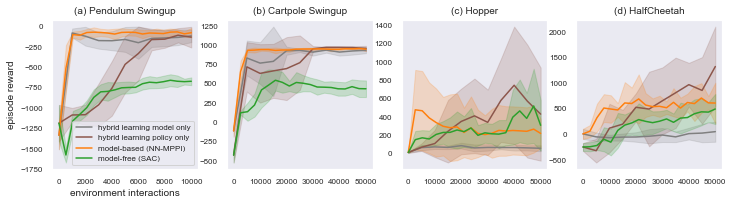

In [19]:
bullet = False
if bullet: 
    envs = ['PendulumEnv','InvertedPendulumBulletEnv','HopperEnv','HalfCheetahEnv'] 
else: 
    envs = ['PendulumEnv','InvertedPendulumRoboschoolEnv','HopperEnv','HalfCheetahEnv'] #,'InvertedPendulumEnv_sin']
# envs = ['PendulumEnv','InvertedPendulumEnv','HopperEnv','HalfCheetah']
plot_titles = ['(a) Pendulum Swingup', '(b) Cartpole Swingup', '(c) Hopper', '(d) HalfCheetah']

fig, axs = plt.subplots(1, len(envs), figsize=(len(envs)*3,2.75))
path_dir = '../data/hlt_stoch/'

for i, env in enumerate(envs):
    got_data = False
    try: 
        model_data_path = '../data/mpc_stoch/' + env +'/'
        model_based_data = process_data(model_data_path)
        
        policy_data_path = '../data/sac__/' + env +'/'
        model_free_data = process_data(policy_data_path)


        policy_data = pickle.load(open(path_dir+env+'/policy_test/reward_data.pkl', 'rb'))
        policy_data_set = get_log(policy_data,model_free_data)
        
        got_data = True                

        model_data = pickle.load(open(path_dir+env+'/model_test/reward_data.pkl', 'rb'))
        model_data_set = get_log(model_data,model_based_data)
        print('policy',np.array(policy_data).shape,
              'model', np.array(model_data).shape)
    except: # placeholder
        model_data_set['x'] = 0
        model_data_set['mean'] = 0
        pass
    if got_data: 
        ax = axs[i]
        plot_data(ax,model_data_set,color='tab:gray',label='hybrid learning model only')
        plot_data(ax,policy_data_set,color='tab:brown',label='hybrid learning policy only')          
        plot_data(ax,model_based_data,color='tab:orange',label='model-based (NN-MPPI)')
        plot_data(ax,model_free_data,color='tab:green',label='model-free (SAC)')
        axs[i].tick_params(axis='both', which='major', labelsize=8)
        axs[i].set_title(plot_titles[i], fontsize=10)
axs[0].set_ylabel('episode reward',fontsize=10)
axs[0].set_xlabel('environment interactions',fontsize=10)
axs[0].legend(ncol=1, fontsize=8)
# axs[0].legend(bbox_to_anchor=(0.,-0.2), loc="upper left", ncol=2, fontsize=8)
if bullet: 
    plt.savefig('component_analysis_bullet.pdf')
else:
    plt.savefig('component_analysis.pdf')


# single plot

In [9]:
env = 'PendulumEnv'

model_data_path = '../data/mpc_stoch/' + env +'/'
model_based_data = process_data(model_data_path)

policy_data_path = '../data/sac__/' + env +'/'
model_free_data = process_data(policy_data_path)

model_data = pickle.load(open('../data/hlt_stoch/'+env+'/model_test/reward_data.pkl', 'rb'))
model_data_set = get_log(model_data,model_based_data)

policy_data = pickle.load(open('../data/hlt_stoch/'+env+'/policy_test/reward_data.pkl', 'rb'))
policy_data_set = get_log(policy_data,model_free_data)

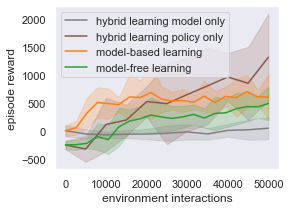

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

plot_data(ax,model_data_set,color='tab:gray',label='hybrid learning model only')
plot_data(ax,policy_data_set,color='tab:brown',label='hybrid learning policy only')          
plot_data(ax,model_based_data,color='tab:orange',label='model-based learning')
plot_data(ax,model_free_data,color='tab:green',label='model-free learning')

plt.ylabel('episode reward')
plt.xlabel('environment interactions')
plt.legend()

# plt.savefig('./component_analysis.pdf')

(20, 10, 2)